In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# import required package

import os
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd

from sklearn import preprocessing
from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt

In [4]:
(x,y),(x_test,y_test) = datasets.mnist.load_data()
# 確認訓練資料維度
print(x.shape,y.shape)
# 確認測試資料維度
print(x_test.shape,y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [5]:
# 進行資料數值調整
def feature_scale(x,y):
  x = tf.cast(x,dtype=tf.float32)/255.
  y = tf.cast(y,dtype=tf.int32)
  return x,y

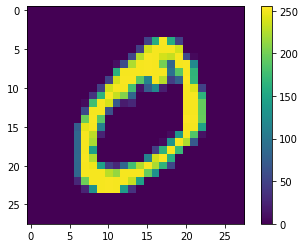

In [6]:
plt.figure()
plt.imshow(x[1])
plt.colorbar()
plt.grid(False)

In [7]:
x = tf.expand_dims(x,axis=3)
x_test = tf.expand_dims(x_test,axis=3)
# 做成訓練及測試用資料集
train_data = tf.data.Dataset.from_tensor_slices((x,y))
train_data = train_data.map(feature_scale).shuffle(10000).batch(512)

data_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
data_test = data_test.map(feature_scale).batch(512) 

In [8]:
# 檢查資料集格式
data_iter = iter(train_data)
samples = next(data_iter)
print(samples[0].shape,samples[1].shape)

(512, 28, 28, 1) (512,)


In [9]:
# 建構卷積層加上Batch Normalization
class ConvBNRelu(keras.Model):
    def __init__(self, channel_num, kernelsize=(3, 3), strides=1, padding='SAME'):
        super(ConvBNRelu, self).__init__()
        self.model = Sequential([
            layers.Conv2D(channel_num, kernelsize, strides=strides, padding=padding),
            layers.BatchNormalization(),   # 增加Batch Normalization
            layers.ReLU()
        ])

    def call(self, inputs, training=None):
        inputs = self.model(inputs, training=training)
        return inputs

# 建構Inception的結構
class Inceptionblock(keras.Model):
    def __init__(self, channel_num, strides=1):
        super(Inceptionblock, self).__init__()

        self.channel_num = channel_num
        self.strides = strides

        self.conv1 = ConvBNRelu(channel_num, strides=strides)
        self.conv2 = ConvBNRelu(channel_num, kernelsize=(3, 3), strides=strides)
        self.conv3 = ConvBNRelu(channel_num, kernelsize=(3, 3), strides=strides)
        self.conv4 = ConvBNRelu(channel_num, kernelsize=(3, 3), strides=1)

        self.pool = keras.layers.MaxPooling2D(3, strides=1, padding='SAME')
        self.pool_conv = ConvBNRelu(channel_num, strides=strides)

    def call(self, inputs, training=None):

        x1 = self.conv1(inputs, training=training)

        x2 = self.conv2(inputs, training=training)

        x3 = self.conv3(inputs, training=training)
        x4 = self.conv4(x3, training=training)

        x5 = self.pool(inputs)
        x5 = self.pool_conv(x5, training=training)
        # 將四個卷積核疊加在一起
        x = tf.concat([x1, x2, x4, x5], axis=3)

        return x


class GoogleNet(keras.Model):
    def __init__(self, num_layers, num_classes, init_channel=16, **kwargs):
        super(GoogleNet, self).__init__(**kwargs)

        self.input_channel = init_channel
        self.output_channel = init_channel
        self.num_classes = num_classes
        self.init_channel = init_channel

        self.conv1 = ConvBNRelu(init_channel)
        self.blocks = Sequential(name='dynamic-blocks')

        for block_id in range(num_layers):
            for layer_id in range(2):
                if layer_id == 0:
                    block = Inceptionblock(self.output_channel, strides=2)
                else:
                    block = Inceptionblock(self.output_channel, strides=1)

                self.blocks.add(block)
            # Increase output dimension per block
            self.output_channel *= 2

        self.avg_pool = keras.layers.GlobalAveragePooling2D()
        self.fc = keras.layers.Dense(num_classes)

    def call(self, inputs, training=None):
        out = self.conv1(inputs, training=None)
        out = self.blocks(out, training=None)
        out = self.avg_pool(out)
        out = self.fc(out)

        return out

In [10]:
# 先建置 Inception 模型
Inception = GoogleNet(5, 10)
Inception.build(input_shape=(None, 28, 28, 1))
# 優化器選擇Adam
optimizers = keras.optimizers.Adam(learning_rate=1e-3)

In [11]:
 # 查看模型架構
Inception.summary()

Model: "google_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_bn_relu (ConvBNRelu)    multiple                  224       
_________________________________________________________________
dynamic-blocks (Sequential)  multiple                  20442848  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  10250     
Total params: 20,453,322
Trainable params: 20,443,370
Non-trainable params: 9,952
_________________________________________________________________


In [12]:
EPOCHS = 10
for i in range(EPOCHS):    
    for step, (x, y) in enumerate(train_data):
        with tf.GradientTape() as tape:
            logits = Inception(x)
            y_onehot = tf.one_hot(y, depth=10)
            loss = tf.losses.categorical_crossentropy(y_onehot, logits, from_logits=True)
            loss = tf.reduce_mean(loss)

        grads = tape.gradient(loss, Inception.trainable_variables)
        optimizers.apply_gradients(zip(grads, Inception.trainable_variables))
        # 每100步檢查loss
        if step % 100 == 0:
            print('Epoch:', i, 'Step: ', step, '\n', 'Loss = ', float(loss))
 
  # 每訓練一個EPOCHS後用測試資料集驗證準確度
    total_num = 0
    total_correct = 0

    for x, y in data_test:
          logits = Inception(x)
          prob = tf.nn.softmax(logits, axis=1)
          pred = tf.argmax(prob, axis=1)
          pred = tf.cast(pred, dtype=tf.int32)

          correct = tf.cast(tf.equal(pred, y), dtype=tf.int32)
          correct = tf.reduce_sum(correct)

          total_num += x.shape[0]
          total_correct += int(correct)

    acc = total_correct / total_num
    print("Accuracy:", acc)

Epoch: 0 Step:  0 
 Loss =  2.302610397338867
Epoch: 0 Step:  100 
 Loss =  0.19899924099445343
Accuracy: 0.9667
Epoch: 1 Step:  0 
 Loss =  0.14166443049907684
Epoch: 1 Step:  100 
 Loss =  0.07805325835943222
Accuracy: 0.9809
Epoch: 2 Step:  0 
 Loss =  0.0583396814763546
Epoch: 2 Step:  100 
 Loss =  0.03837265074253082
Accuracy: 0.9823
Epoch: 3 Step:  0 
 Loss =  0.04659903049468994
Epoch: 3 Step:  100 
 Loss =  0.05061204358935356
Accuracy: 0.9831
Epoch: 4 Step:  0 
 Loss =  0.043252669274806976
Epoch: 4 Step:  100 
 Loss =  0.007349352352321148
Accuracy: 0.9885
Epoch: 5 Step:  0 
 Loss =  0.026044782251119614
Epoch: 5 Step:  100 
 Loss =  0.008888970129191875
Accuracy: 0.9916
Epoch: 6 Step:  0 
 Loss =  0.010374556295573711
Epoch: 6 Step:  100 
 Loss =  0.006592452060431242
Accuracy: 0.9933
Epoch: 7 Step:  0 
 Loss =  0.004830255173146725
Epoch: 7 Step:  100 
 Loss =  0.011290918104350567
Accuracy: 0.991
Epoch: 8 Step:  0 
 Loss =  0.022299576550722122
Epoch: 8 Step:  100 
 Loss 